In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import time
%matplotlib inline
import sys
sys.path.append('./')

# from intersections_and_roads import *
from final_project import *
# from search import *
from shapely.geometry import *
import ast

**Cambridge Graph**

In [2]:
cambridge_map = map_structure(city='Cambridge')

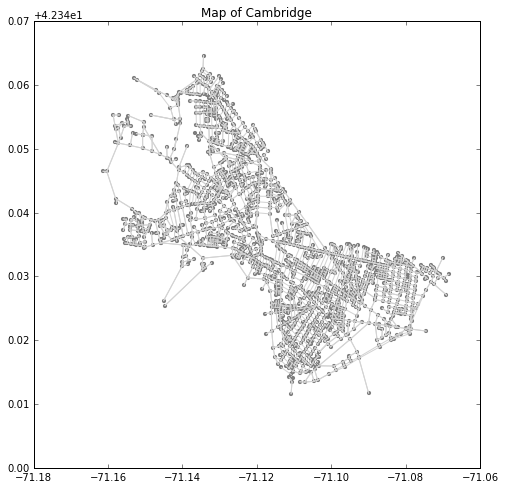

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph(ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

**San Francisco**

In [4]:
san_fran_map = map_structure(city='San Francisco')

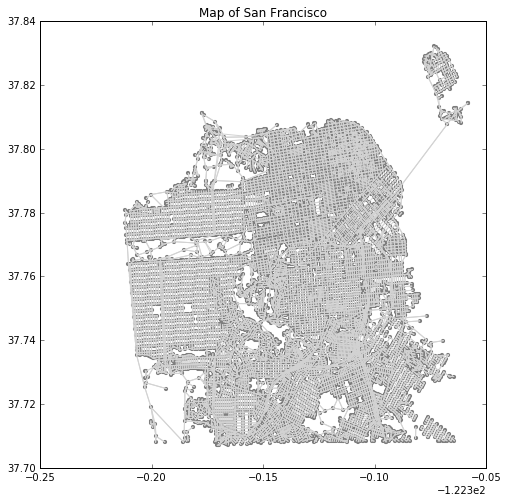

In [5]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph(ax=ax)
ax.set_title('Map of San Francisco')
plt.show()

### Section 1: Graph Search - A*

In [6]:
# randomly select a start and an end point on the graph for test
intersection_graph = san_fran_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [7]:
# search the graph
route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_road_cost,
                                   heuristic=san_fran_map.null_heuristic)
safe_route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_safe_road_cost,
                                   heuristic=san_fran_map.null_heuristic)

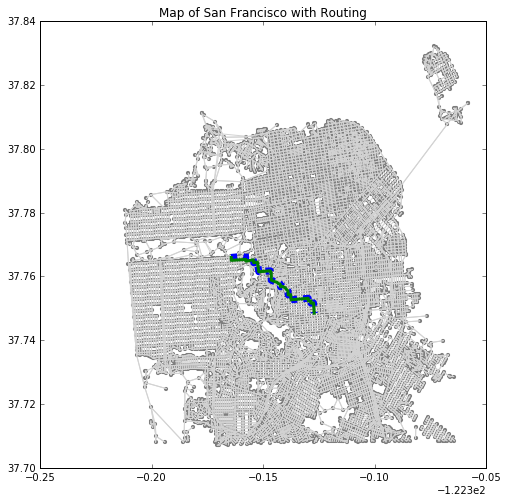

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph([route['nodes']], [safe_route['nodes']], ax=ax)
ax.set_title('Map of San Francisco with Routing')
plt.show()

**Lets collect some data:**

In [32]:
def sim(start, end, cost_fn, heuristic_fn, map_to_test):
    route, nodes_expanded = map_to_test.a_star_search(start,
                                   end,
                                   road_cost=cost_fn,
                                   heuristic=heuristic_fn,
                                   return_expanded_nodes = True)
    
    solution_distance = map_to_test.get_road_cost(route['nodes'], route['connections'])
    delta_elev = np.sum([map_to_test.road_connections[conn].delta_elevation for conn in route['connections']])
    return (route['nodes'], solution_distance, delta_elev, len(nodes_expanded))

def execute_simulation(nsims, cost_fn, heuristic_fn, map_to_test=san_fran_map):
    euclidean_dist = []
    solution_nodes = [[],[],[]]
    solution_route_distance = [[],[],[]]
    solution_delta_elevation = [[],[],[]]
    solution_nodes_expanded = [[],[],[]]

    for i in range(nsims):
        try:
            start = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            euclid_dist = 0
            while (end.id == start.id) or ((euclid_dist < 0.02) or (euclid_dist > 0.15)):
                end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
                euclid_dist = euclidean_distance(start.get_x_y(), end.get_x_y())

            # under the null heuristic
            result0 = sim(start, end, cost_fn[0], heuristic_fn[0], map_to_test)

            # under the euclidean_heuristic heuristic
            result1 = sim(start, end, cost_fn[1], heuristic_fn[1], map_to_test)

            # under the combined_heuristic heuristic
            result2 = sim(start, end, cost_fn[2], heuristic_fn[2], map_to_test)
            
            euclidean_dist.append(euclid_dist)
            
            k = 0
            solution_nodes[k].append(result0[0])
            solution_route_distance[k].append(result0[1])
            solution_delta_elevation[k].append(result0[2])
            solution_nodes_expanded[k].append(result0[3])
            
            k = 1
            solution_nodes[k].append(result1[0])
            solution_route_distance[k].append(result1[1])
            solution_delta_elevation[k].append(result1[2])
            solution_nodes_expanded[k].append(result1[3])
            
            k = 2
            solution_nodes[k].append(result2[0])
            solution_route_distance[k].append(result2[1])
            solution_delta_elevation[k].append(result2[2])
            solution_nodes_expanded[k].append(result2[3])
        except:
            print 'problem', start, end
        
    return euclidean_dist, solution_nodes, solution_route_distance, solution_delta_elevation, solution_nodes_expanded

#watch out for this number. The larger it is the longer this will all take!!! (100 is MASSIVE)
nsim = 100

Basic road cost

In [33]:
# Cost function = get_road_cost ## I.e. simple road cost
cost_fn = [cambridge_map.get_road_cost, cambridge_map.get_road_cost, cambridge_map.get_road_cost]
heuristic = [cambridge_map.null_heuristic, cambridge_map.euclidean_heuristic, cambridge_map.combined_heuristic]

result = execute_simulation(nsim, cost_fn, heuristic, cambridge_map)

euclidean_dist = np.array(result[0])
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 1008, x: -71.1034204623, y: 42.3740586597 
Connections: set([u'Cambrid_St_35', u'Cambrid_St_34', u'Maple_Ave_2']) <Node> id: 1846, x: -71.1134083047, y: 42.3557290705 
Connections: set([])
problem <Node> id: 1612, x: -71.1024356145, y: 42.3628637226 
Connections: set([u'Frankli_St_3', u'Brookli_St_21']) <Node> id: 1268, x: -71.1555895182, y: 42.3758396724 
Connections: set([u'Thingva_Ave_3'])


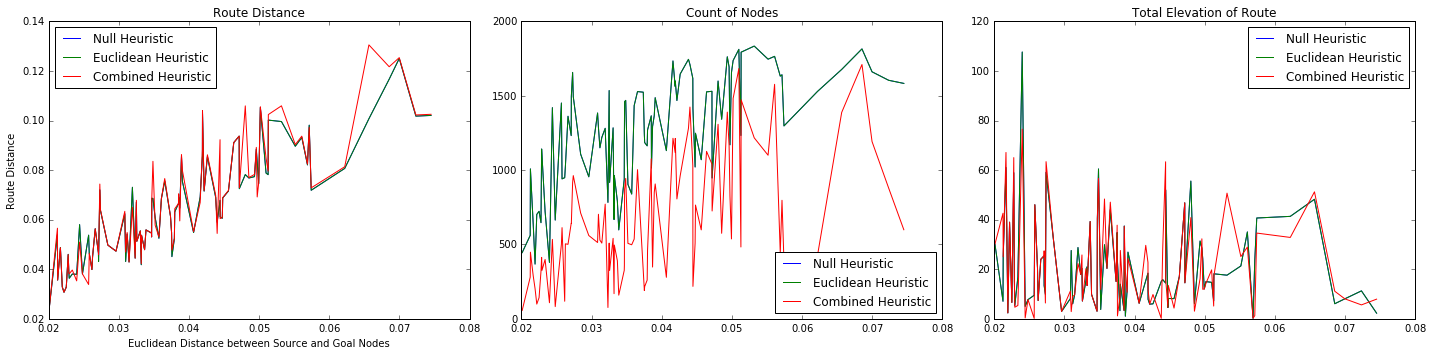

In [39]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)
solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost

In [35]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [cambridge_map.get_safe_road_cost, cambridge_map.get_safe_road_cost, cambridge_map.get_safe_road_cost]
result = execute_simulation(nsim, cost_fn, heuristic, cambridge_map)

euclidean_dist = np.array(result[0])
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 254, x: -71.1235355123, y: 42.3880046253 
Connections: set([u'Cambrid_Ter_2', u'Herbert_St_1']) <Node> id: 1181, x: -71.0793846034, y: 42.3702316026 
Connections: set([])
problem <Node> id: 1319, x: -71.1368774116, y: 42.3727282008 
Connections: set([u'Coolidg_Hil_1']) <Node> id: 1049, x: -71.1055109409, y: 42.3732635647 
Connections: set([u'Highlan_Ave_2', u'Highlan_Ave_3', u'Highlan_Pk_1'])
problem <Node> id: 1764, x: -71.1010698352, y: 42.3660918081 
Connections: set([]) <Node> id: 447, x: -71.1164000119, y: 42.3808487706 
Connections: set([u'Oxford_St_4', u'Hammond_St_2', u'Oxford_St_3'])
problem <Node> id: 1608, x: -71.0936370222, y: 42.3629697353 
Connections: set([u'Main_St_9', u'Main_St_10', u'Portlan_St_1', u'Portlan_St_2']) <Node> id: 1833, x: -71.1280323641, y: 42.3983302585 
Connections: set([u'Elmwood_St_1'])
problem <Node> id: 128, x: -71.1264807644, y: 42.3970846097 
Connections: set([]) <Node> id: 1150, x: -71.1068488472, y: 42.3716150678 
Connections

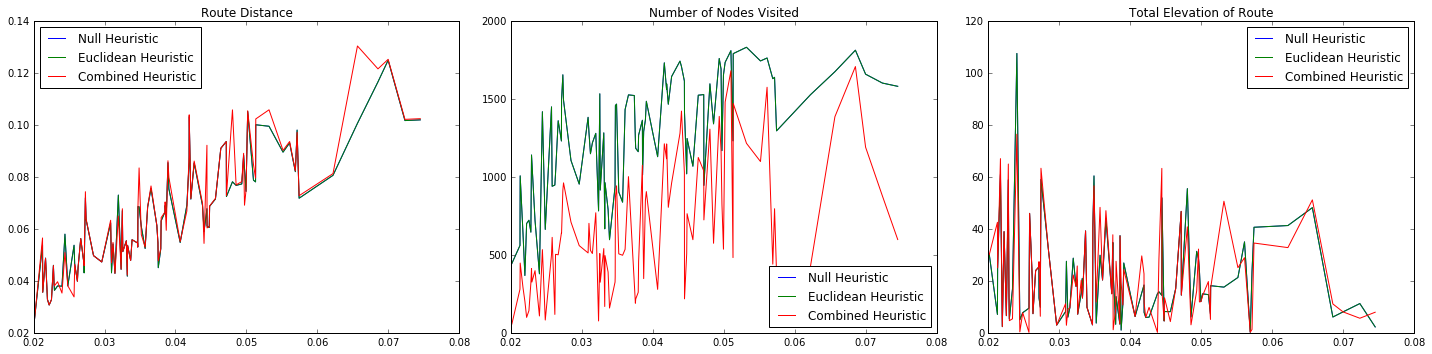

In [40]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost with Elevation

In [37]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [cambridge_map.get_safe_road_cost_with_elevation,
           cambridge_map.get_safe_road_cost_with_elevation,
           cambridge_map.get_safe_road_cost_with_elevation]
result = execute_simulation(nsim, cost_fn, heuristic, cambridge_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 1302, x: -71.098700626, y: 42.3742017767 
Connections: set([u'Clary_St_1']) <Node> id: 1833, x: -71.1280323641, y: 42.3983302585 
Connections: set([u'Elmwood_St_1'])
problem <Node> id: 111, x: -71.1291844502, y: 42.4003391984 
Connections: set([]) <Node> id: 1294, x: -71.1234611842, y: 42.3747530426 
Connections: set([u'Fuller_Pl_1'])
problem <Node> id: 730, x: -71.1030674036, y: 42.3598582637 
Connections: set([u'Tudor_St_1', u'Sidney_St_10']) <Node> id: 263, x: -71.1357067435, y: 42.3919854007 
Connections: set([u'Jackson_Cir_2'])
problem <Node> id: 1296, x: -71.0913049771, y: 42.3745622198 
Connections: set([]) <Node> id: 731, x: -71.1102958142, y: 42.3598317605 
Connections: set([u'Allston_St_6', u'Magazin_St_8', u'Magazin_St_9'])
problem <Node> id: 1321, x: -71.0818560137, y: 42.3723730583 
Connections: set([u'Mullins_Ct_1']) <Node> id: 1857, x: -71.1004566281, y: 42.3640934695 
Connections: set([])
problem <Node> id: 483, x: -71.1313028018, y: 42.3795660174 
Co

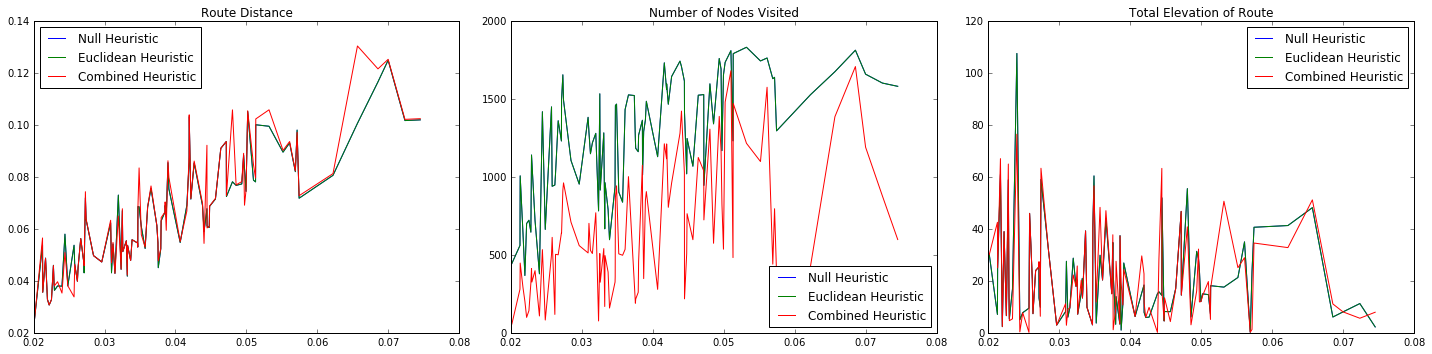

In [41]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

In [48]:
cost_fn = [san_fran_map.get_road_cost, san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost_with_elevation]
heuristic = [san_fran_map.null_heuristic, san_fran_map.null_heuristic, san_fran_map.null_heuristic]

result = execute_simulation(100, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 22407000, x: -122.448982234, y: 37.7405413738 
Connections: set([12505000, 12506000, 11763000]) <Node> id: 50933000, x: -122.412104017, y: 37.7337807817 
Connections: set([3752000])
problem <Node> id: 51962000, x: -122.372034794, y: 37.7109878794 
Connections: set([5108000, 5109000, 4854000, 4853000]) <Node> id: 27108000, x: -122.466862334, y: 37.7565339993 
Connections: set([9335000, 474000, 9336000, 475000])
problem <Node> id: 52034000, x: -122.426929894, y: 37.7464994344 
Connections: set([19763000]) <Node> id: 25090000, x: -122.41391588, y: 37.7904631147 
Connections: set([7576000, 10472000])
problem <Node> id: 24595000, x: -122.399369534, y: 37.7858992476 
Connections: set([7037000, 6809000]) <Node> id: 51598000, x: -122.459025182, y: 37.7417947616 
Connections: set([19786000])


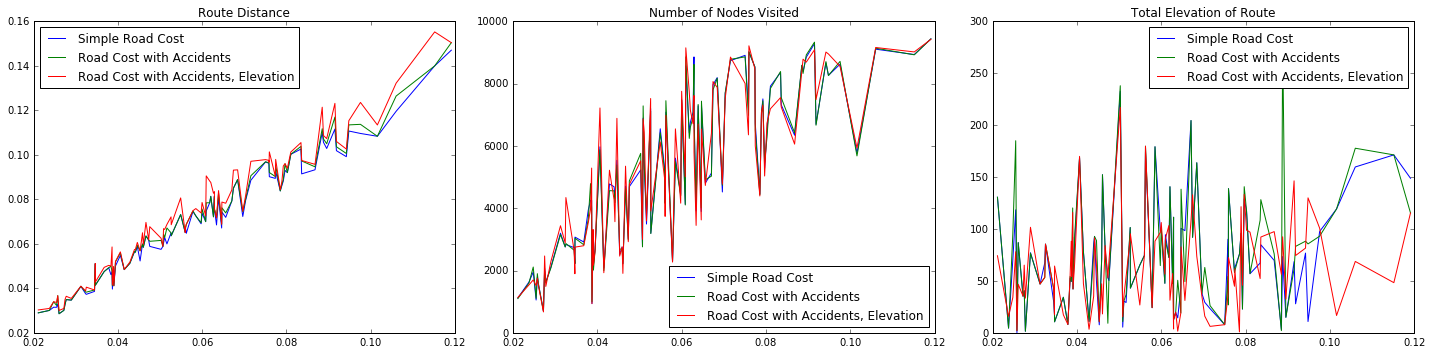

In [49]:
## Compare cost function 
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Simple Road Cost', 'Road Cost with Accidents', 'Road Cost with Accidents, Elevation']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Local Search: Simulated Annealing, K-Beam

In [6]:
intersection_graph = cambridge_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

route = cambridge_map.a_star_search(start, end, cambridge_map.get_road_cost, cambridge_map.null_heuristic)

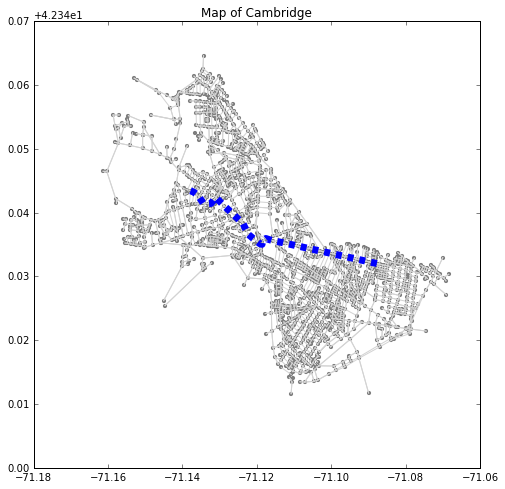

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph([route['nodes']], ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

In [5]:
# define which map type you want to run
test_map = san

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

heuristic_fns = [test_map.null_heuristic, test_map.euclidean_heuristic, test_map.combined_heuristic]
times_annealing = []
times_k_beam = []
costs_annealing = []
costs_k_beam = []

for fn in heuristic_fns:
    timer = start - time.clock()
    node_annealing = test_map.simulated_annealing(
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)
    timer_annealing = start - time.clock()
    times_annealing.append(timer_annealing)
    cost = np.sum([test_map.cost(p, node_annealing, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    costs_annealing.append(cost)
    
    timer = start - time.clock()
    node_k_beam = test_map.k_beam_search(k=5,
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)
    timer_k_beam = start - time.clock()
    times_k_beam.append(timer_k_beam)
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    costs_k_beam.append(cost)
# Sorry I am not sure why this is breaking by I am exhausted... :(

iteration  0 best cost 2560.68879626


AttributeError: 'tuple' object has no attribute 'id'

In [ ]:
# I think maybe a bar chart? Not sure

In [4]:
test_map = cambridge_map

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

times = []
costs_k_beam = []
ks = np.linspace(5,35,10)

for k in ks:
    k = int(k)
    start = time.clock()
    node_k_beam = test_map.k_beam_search(k=k,
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)

    timer = start - time.clock()
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    times.append(timer)
    costs.append(cost)
# same comment here

iteration  0 best cost 1951.20813454
iteration  1 best cost 1848.98002698
iteration  2 best cost 1709.5480261
iteration  3 best cost 1585.70198196


AttributeError: 'tuple' object has no attribute 'id'